In [57]:
import pandas as pd
import numpy as np
import copy
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
import sklearn
import matplotlib.pyplot as plt

In [58]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [59]:
# число значений у признаков
max_value = 0
for col_name in data.columns:
    max_value = max(max_value, np.max(data[col_name]))
print(max_value)

312153


In [60]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

In [61]:
def display_auc(y_true, y_predict):
    print("AUC:", sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true))
    (fpr, tpr, thresholds) = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_predict)
    plt.plot(fpr, tpr)
    plt.show()

def get_auc(y_true, y_predict):
    return sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true)

In [63]:
def indicator(x, y, **kwargs):
    return (np.sum(x != y))

In [62]:
#indicator 22 min
neigh_with_indicator = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, algorithm='brute', metric=indicator)
neigh_with_indicator.fit(X_train, y_train)
y_with_indicator = neigh_with_indicator.predict_proba(X_test)

y_with_indicator = y_with_indicator[:, 1]

display_auc(y_true = y_test, y_predict = y_with_indicator)

KeyboardInterrupt: 

In [64]:
def unique_with_count(input_array): # (value, count)
    buf = copy.deepcopy(input_array)
    buf = buf[buf == buf]
    buf = np.sort(buf)
    
    Y = np.concatenate((buf[1:], np.array([np.nan])))
    lens_seg = np.cumsum(np.ones(buf.shape[0]))
    val = buf[buf != Y]
    lens_seg = lens_seg[buf != Y]
    lens_seg = np.asarray(np.concatenate((lens_seg[0:1], np.diff(lens_seg))), dtype = int)
    return (val, lens_seg)


p_2 = np.zeros((X_train.shape[1], max_value + 1))
p = np.zeros((X_train.shape[1], max_value + 1))
f = np.zeros((X_train.shape[1], max_value + 1))
for col in range(X_train.shape[1]):
    (unique_value, count) = unique_with_count(X_train.iloc[:, col])
    cur_f = count
    cur_p = (count + 0.0) / X_train.shape[0]
    cur_p_2 = count * (count - 1.0) / X_train.shape[0] / (X_train.shape[0] - 1)
    sum_p_2 = np.zeros(unique_value.shape[0])
    for i in range(unique_value.shape[0]):
        sum_p_2[i] = np.sum(cur_p_2[cur_p < cur_p[i]])
    
    f[col][unique_value] = cur_f
    p[col][unique_value] = cur_p
    p_2[col][unique_value] = sum_p_2
    
log_f = np.log(f + 1)


In [65]:
def smoothed_indicator(x, y, **kwargs):
    buf = kwargs['p_2']
    return np.sum((x != y) + (x == y) * buf[:, np.asarray(x, int)])


AUC: 0.833989009583


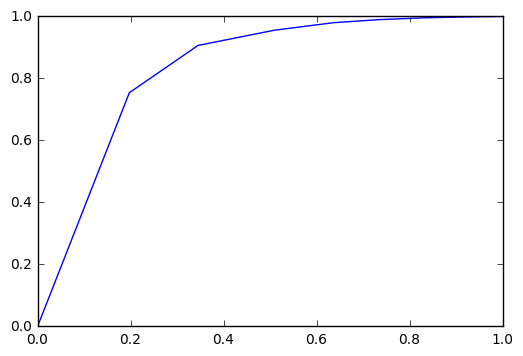

In [192]:
#smoothed_indicator
neigh_with_smoothed_indicator = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, algorithm='brute', metric=smoothed_indicator, 
                                                                       metric_params={'p_2': p_2})
neigh_with_smoothed_indicator.fit(X_train, y_train)


y_with_smoothed_indicator = neigh_with_smoothed_indicator.predict_proba(np.asarray(X_test, int))
y_with_smoothed_indicator = y_with_smoothed_indicator[:, 1]

display_auc(y_true = y_test, y_predict = y_with_smoothed_indicator)

In [67]:
def log_indicator(x, y, **kwargs):
    buf = kwargs['log_f']
    return np.sum((x != y) * buf[:, np.asarray(x, int)] * buf[:, np.asarray(y, int)])

AUC: 0.819376603473


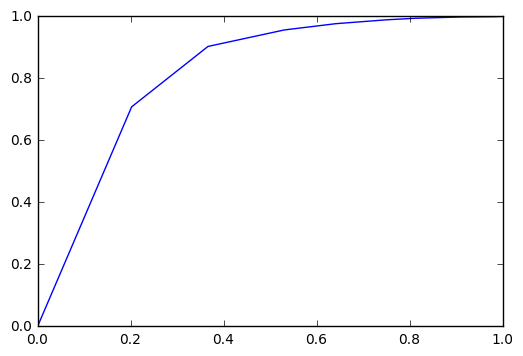

In [194]:
#log_indicator
neigh_with_log_indicator = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, algorithm='brute', 
                                                              metric=log_indicator,
                                                             metric_params={'log_f': log_f})
neigh_with_log_indicator.fit(X_train, y_train)
y_with_log_indicator = neigh_with_log_indicator.predict_proba(np.asarray(X_test, int))

y_with_log_indicator = y_with_log_indicator[:, 1]
display_auc(y_true = y_test, y_predict = y_with_log_indicator)

In [68]:
def find_optimal_k(X_train, y_train, X_test, y_test, MAXK, metric, metric_params = None):
    MAXK += 1
    classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=MAXK, 
                                                        algorithm='brute', 
                                                        metric=metric,
                                                        metric_params=metric_params)
    classifier.fit(X_train, y_train)
    nearest_class = classifier.kneighbors(X_test, return_distance=0)
    precision = np.ndarray((MAXK, X_test.shape[0], 2))
    for ind_object in range(X_test.shape[0]):
        histohram = np.zeros(2)
        for k in range(0, MAXK):
            histohram[y_train.iloc[nearest_class[ind_object][k]]] += 1
            precision[k, ind_object] = histohram / (k + 1)
    
    max_auc = 0.0
    max_k = 0;
    for k in range(0, MAXK):
        y_predict = precision[k, :, 1]
        cur_auc = get_auc(y_true = y_test, y_predict = y_predict)
        if (cur_auc > max_auc):
            max_auc = cur_auc
            max_k = k + 1
        
    return (max_auc, max_k)

In [69]:
print( find_optimal_k(X_train, y_train, X_test, y_test, 15, log_indicator, metric_params={'log_f': log_f}) )

(0.82167888343285744, 9)


In [70]:
print( find_optimal_k(X_train, y_train, X_test, y_test, 15, smoothed_indicator, metric_params={'p_2': p_2}) )

(0.83469194987351925, 10)


In [71]:
print( find_optimal_k(X_train, y_train, X_test, y_test, 15, indicator) )

(0.83094973406339201, 9)


In [44]:
def get_count_and_successed(X_train, y_train):
    count = [{} for i in range(X_train.shape[1])]
    successed = [{} for i in range(X_train.shape[1])]
    for col in range(X_train.shape[1]):
        value, len = unique_with_count(X_train.iloc[:, col])
        
        count[col] = {cur_value: 0 for cur_value in value}
        successed[col] = {cur_value: 0 for cur_value in value}
        for ind in range(X_train.shape[0]):
            count[col][X_train.iloc[ind, col]] += 1
            successed[col][X_train.iloc[ind, col]] += (y_train.iloc[ind] == 1)
        for cur_value in value:
            count[col][cur_value] /= y_train.shape[0]
            successed[col][cur_value] /= y_train.shape[0]
            
    return (count, successed)

In [45]:
count, successed = get_count_and_successed(X_train, y_train)

In [46]:
def get_new_features(X, count, successed):
    cnt = 0
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            new_X[i, 3 * j] = count[j].get(X.iloc[i, j], 0)
            new_X[i, 3 * j + 1] = successed[j].get(X.iloc[i, j], 0)
            new_X[i, 3 * j + 2] = (new_X[i, 3 * j + 1] + 1) / (new_X[i, 3 * j] + 2)
            cnt += new_X[i, 3 * j] == 0;
    print(cnt)
    return new_X




In [48]:

new_X_train = get_new_features(X_train, count, successed)
new_X_test = get_new_features(X_test, count, successed)


0
2214


AUC: 0.788718055439


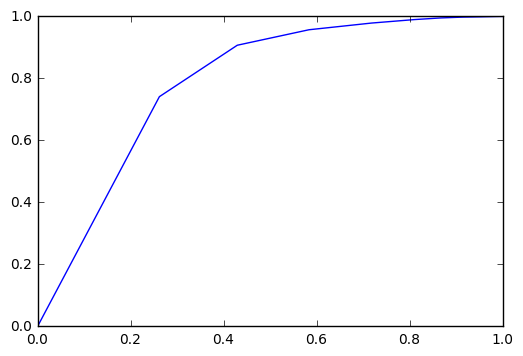

In [49]:
#WITHOUT FOLDING
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, 
                                               algorithm='brute', 
                                               metric='euclidean')

neigh.fit(new_X_train, y_train)


y = neigh.predict_proba(new_X_test)
y = y[:, 1]

display_auc(y_true = y_test, y_predict = y)

In [50]:
find_optimal_k(new_X_train, y_train, new_X_test, y_test, MAXK=15, metric='euclidean') #WITHOUT FOLDING

(0.79678798609179213, 14)

In [51]:
def get_new_features_with_fold(X, y, CNT_FOLDS = 3):
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(CNT_FOLDS):
        ind = np.ndarray(((X.shape[0] + CNT_FOLDS - 1 - i) // CNT_FOLDS), dtype=int)
        other_ind = np.ndarray(X.shape[0] - ind.shape[0], dtype=int)
        cnt = 0
        cnt_other = 0
        for j in range(X.shape[0]):
            if (j % CNT_FOLDS == i):
                ind[cnt] = j
                cnt += 1
            else:
                other_ind[cnt_other] = j
                cnt_other += 1

        count, successed = get_count_and_successed(X.iloc[other_ind, :], y.iloc[other_ind])
        X_chunk_new = get_new_features(X.iloc[ind, :], count, successed)
        new_X[ind, :] = X_chunk_new
    return new_X


2383
2421
2411
2214
AUC: 0.763562263815


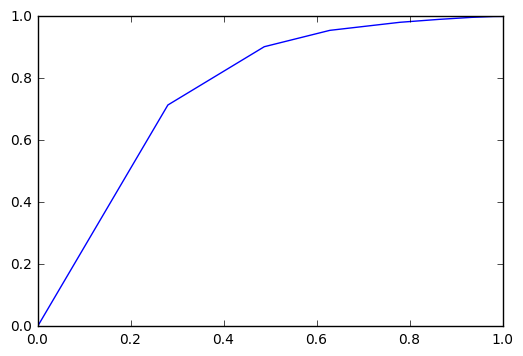

In [52]:
#WITH FOLDING
CNT_FOLDS = 3
new_X_train = get_new_features_with_fold(X_train, y_train, CNT_FOLDS)


count, successed = get_count_and_successed(X_train, y_train)
new_X_test = get_new_features(X_test, count, successed)


neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, 
                                               algorithm='brute', 
                                               metric='euclidean')

neigh.fit(new_X_train, y_train)


y = neigh.predict_proba(new_X_test)
y = y[:, 1]

display_auc(y_true = y_test, y_predict = y)

In [54]:
find_optimal_k(new_X_train, y_train, new_X_test, y_test, MAXK=30, metric='euclidean') #WITH FOLDING

(0.77708562015813154, 16)

In [20]:
def get_pair_features(X):
    print("Begin")
    X_new = np.ndarray((X.shape[0], X.shape[1] * (X.shape[1] + 1) // 2))
    X_new[:, 0:X.shape[1]] = copy.deepcopy(X.iloc[:])
    print("End copy")
    len = X.shape[1]
    for i in range(X.shape[1]):
        print("Processing", i, "features")
        for j in range(i + 1, X.shape[1]):
            for k in range(X.shape[0]):
                X_new[k, len] = str(X.iloc[k, i]) + "0123321" + str(X.iloc[k, j])
            len += 1
    return X_new

In [21]:
X_train_with_pair_features = get_pair_features(X_train)

Begin
End copy
Processing 0 features
Processing 1 features
Processing 2 features
Processing 3 features
Processing 4 features
Processing 5 features
Processing 6 features
Processing 7 features
Processing 8 features


In [22]:
X_test_with_pair_features = get_pair_features(X_test)

Begin
End copy
Processing 0 features
Processing 1 features
Processing 2 features
Processing 3 features
Processing 4 features
Processing 5 features
Processing 6 features
Processing 7 features
Processing 8 features


In [30]:
def get_new_features(X, count, successed):
    cnt = 0
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            new_X[i, 3 * j] = count[j].get(X[i, j], 0)
            new_X[i, 3 * j + 1] = successed[j].get(X[i, j], 0)
            new_X[i, 3 * j + 2] = (new_X[i, 3 * j + 1] + 1) / (new_X[i, 3 * j] + 2)
            cnt += new_X[i, 3 * j] == 0;
    print(cnt)
    return new_X

def get_count_and_successed(X_train, y_train):
    count = [{} for i in range(X_train.shape[1])]
    successed = [{} for i in range(X_train.shape[1])]
    for col in range(X_train.shape[1]):
        value, len = unique_with_count(X_train[:, col])
        
        count[col] = {cur_value: 0 for cur_value in value}
        successed[col] = {cur_value: 0 for cur_value in value}
        for ind in range(X_train.shape[0]):
            count[col][X_train[ind, col]] += 1
            successed[col][X_train[ind, col]] += (y_train[ind] == 1)
        for cur_value in value:
            count[col][cur_value] /= y_train.shape[0]
            successed[col][cur_value] /= y_train.shape[0]
            successed[col][cur_value] = round(successed[col][cur_value], 1)
            
    return (count, successed)


count, successed = get_count_and_successed(X_train_with_pair_features, np.array(y_train.iloc[:], dtype=int))
new_X_train_with_pair_features = get_new_features(X_train_with_pair_features, count, successed)
new_X_test_with_pair_features = get_new_features(X_test_with_pair_features, count, successed)

0
44734


AUC: 0.80338239808


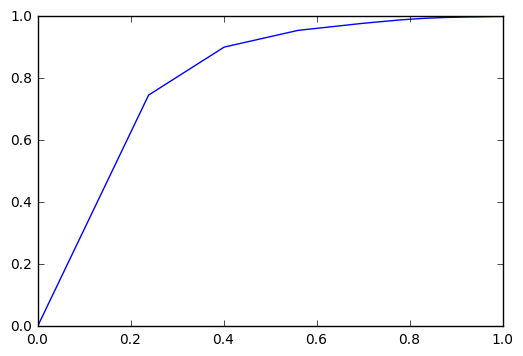

In [31]:
#WITHOUT FOLDING
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, 
                                               algorithm='brute', 
                                               metric='euclidean')

neigh.fit(new_X_train_with_pair_features, y_train)


y = neigh.predict_proba(new_X_test_with_pair_features)
y = y[:, 1]

display_auc(y_true = y_test, y_predict = y)

42718
42865
43297
44734
AUC: 0.786467891722


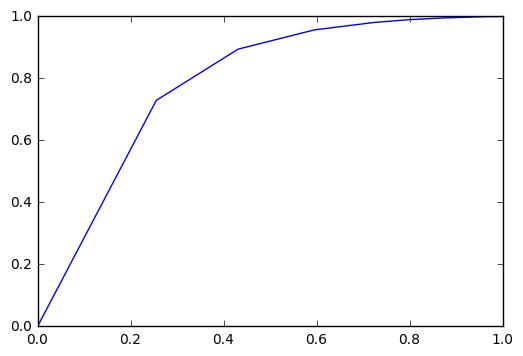

In [36]:
#WITH FOLDING
def get_new_features_with_fold(X, y, CNT_FOLDS = 3):
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(CNT_FOLDS):
        ind = np.ndarray(((X.shape[0] + CNT_FOLDS - 1 - i) // CNT_FOLDS), dtype=int)
        other_ind = np.ndarray(X.shape[0] - ind.shape[0], dtype=int)
        cnt = 0
        cnt_other = 0
        for j in range(X.shape[0]):
            if (j % CNT_FOLDS == i):
                ind[cnt] = j
                cnt += 1
            else:
                other_ind[cnt_other] = j
                cnt_other += 1

        count, successed = get_count_and_successed(X[other_ind, :], y[other_ind])
        X_chunk_new = get_new_features(X[ind, :], count, successed)
        new_X[ind, :] = X_chunk_new
    return new_X

CNT_FOLDS = 3
new_X_train_with_pair_features = get_new_features_with_fold(X_train_with_pair_features, np.array(y_train, dtype=int), CNT_FOLDS)


count, successed = get_count_and_successed(X_train_with_pair_features, np.array(y_train, dtype=int))
new_X_test_with_pair_features = get_new_features(X_test_with_pair_features, count, successed)


neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=10, 
                                               algorithm='brute', 
                                               metric='euclidean')

neigh.fit(new_X_train_with_pair_features, np.array(y_train, dtype=int))


y = neigh.predict_proba(new_X_test_with_pair_features)
y = y[:, 1]

display_auc(y_true = y_test, y_predict = y)